# Intervening on Vision-Language Models

This is a quick tutorial for running interventions on the decoder component of BLIP for visual question answering (support for the text/image encoders TBD). This is partially based on an earlier paper I was on, ["Towards Vision-Language Mechanistic Interpretability: A Causal Tracing Tool for BLIP" (Palit et al., 2023)](https://arxiv.org/abs/2308.14179).

In [1]:
__author__ = "Aryaman Arora"
__version__ = "12/27/2023"

## Setup

In [2]:
try:
    # This library is our indicator that the required installs
    # need to be done.
    import pyvene

except ModuleNotFoundError:
    !pip install git+https://github.com/stanfordnlp/pyvene.git

In [2]:
import torch
import pandas as pd

from pyvene import embed_to_distrib, top_vals, format_token
from pyvene import (
    IntervenableModel,
    VanillaIntervention, Intervention,
    RepresentationConfig,
    IntervenableConfig,
)
from pyvene import create_blip
from pyvene.models.blip.modelings_blip import BlipWrapper

%config InlineBackend.figure_formats = ['svg']
from plotnine import (
    ggplot,
    geom_tile,
    aes,
    facet_wrap,
    theme,
    element_text,
    geom_bar,
    geom_hline,
    scale_y_log10,
)
from plotnine.scales import scale_y_reverse, scale_fill_cmap
from tqdm import tqdm
from PIL import Image
import requests
from functools import partial

## Load model and test inference

We'll load BLIPForQuestionAnswering and use a special `BlipWrapper` to enable easy access of decoder logits; this doesn't modify the model's computations in any way.

In [4]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
config, processor, blip = create_blip(
    cache_dir="/nlp/scr/aryaman/.cache/huggingface/hub"  # change to your local dir
)
blip = BlipWrapper(blip)
blip.to(device)

loaded model


BlipWrapper(
  (model_vis): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-05, elementwise_affin

Now testing some QA on a simple image.

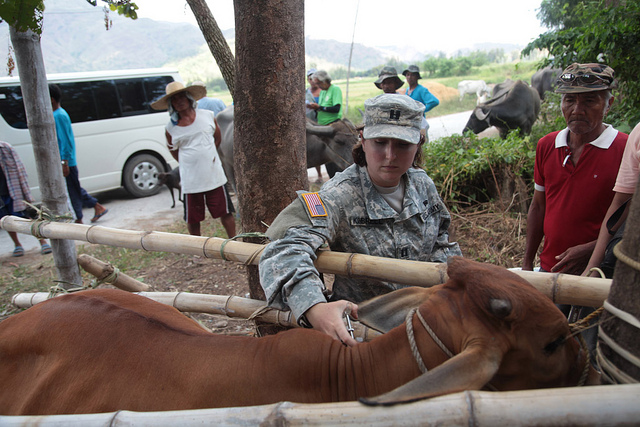

In [5]:
img_url = "http://images.cocodataset.org/train2017/000000458864.jpg"
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")
raw_image

In [19]:
def top_vals(tokenizer, res, n=10):
    """Pretty print the top n values of a distribution over the vocabulary"""
    probs = res.softmax(-1)
    top_values, top_indices = torch.topk(res, n)
    for i in range(len(top_values)):
        tok = format_token(tokenizer, top_indices[i].item())
        print(
            f"{tok:<20} {top_indices[i]:>10} {top_values[i]:>10.5f} {probs[top_indices[i]]:>10.2%}"
        )


question = "what is the color of the shirt"
print(question, "\n----")
inputs = processor(raw_image, question, return_tensors="pt").to(device)
print(inputs["input_ids"].shape)

out = blip(**inputs)
print(out["decoder_logits"].shape)
top_vals(processor, out["decoder_logits"][0, 0])

question = "what is the color of the animal"
print(question, "\n----")
inputs = processor(raw_image, question, return_tensors="pt").to(device)
print(inputs["input_ids"].shape)

out = blip(**inputs)
print(out["decoder_logits"].shape)
top_vals(processor, out["decoder_logits"][0, 0])

what is the color of the shirt 
----
torch.Size([1, 9])
torch.Size([1, 1, 30524])
red                        2417   10.64493     61.74%
white                      2317    9.11390     13.35%
pink                       5061    8.10488      4.87%
green                      2665    7.13710      1.85%
blue                       2630    6.71536      1.21%
gray                       3897    6.63115      1.12%
black                      2304    6.52738      1.01%
brown                      2829    6.42861      0.91%
maroon                    22222    6.03666      0.62%
multi                      4800    5.35350      0.31%
what is the color of the animal 
----
torch.Size([1, 9])
torch.Size([1, 1, 30524])
brown                      2829   11.42929     88.94%
red                        2417    6.36936      0.56%
reddish                   14182    5.54194      0.25%
dark                       2601    5.49398      0.24%
tan                        9092    5.24055      0.18%
light                    

## Vanilla intervention

Let's see at what transformer blocks and position we can swap activations in order to make the model tell the colour of the shirt instead of the animal.

In [20]:
def simple_position_config(model_type, intervention_type, layer):
    config = IntervenableConfig(
        model_type=model_type,
        representations=[
            RepresentationConfig(
                layer,  # layer
                intervention_type,  # intervention type
                "pos",  # intervention unit
                1,  # max number of unit
            ),
        ],
        intervention_types=VanillaIntervention,
    )
    return config


base = processor(raw_image, "what is the color of the animal", return_tensors="pt").to(
    device
)
sources = [
    processor(raw_image, "what is the color of the shirt", return_tensors="pt").to(
        device
    )
]

In [23]:
data = []
with torch.inference_mode():
    for layer_i in tqdm(range(12)):
        for pos_i in range(9):
            config = simple_position_config(
                type(blip), "block_output", layer_i
            )
            intervenable = IntervenableModel(config, blip)
            _, counterfactual_outputs = intervenable(
                base, sources, {"sources->base": ([[[pos_i]]], [[[pos_i]]])}
            )
            logits = counterfactual_outputs["decoder_logits"][0, 0]
            # top_vals(processor, logits, n=1)
            logits = logits.softmax(-1)
            p_brown = logits[2829]
            p_red = logits[2417]
            data.append(
                {
                    "layer": layer_i,
                    "pos": pos_i,
                    "p(brown)": p_brown.item(),
                    "p(red)": p_red.item(),
                }
            )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:15<00:00,  1.32s/it]


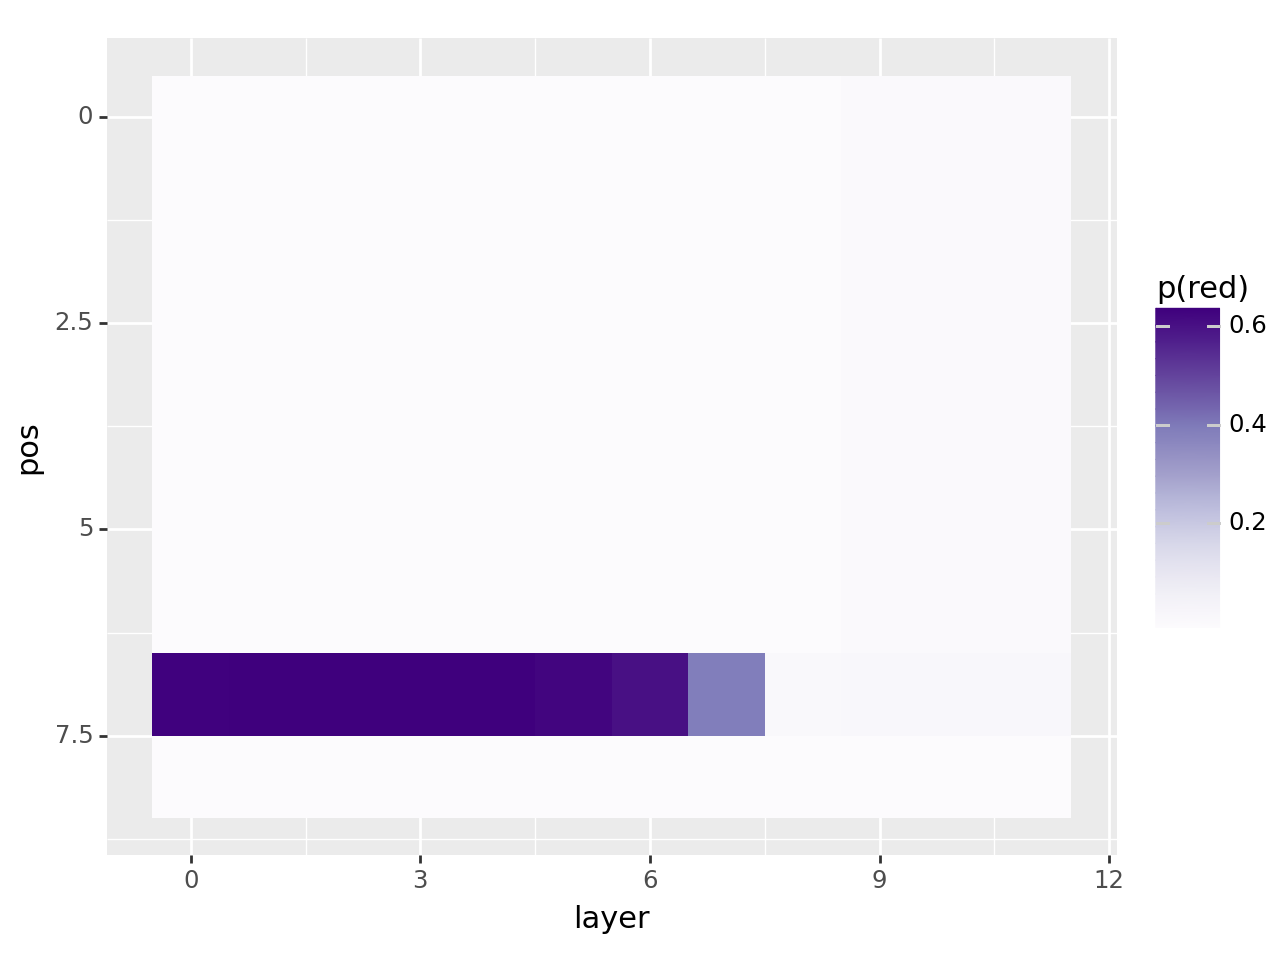

In [26]:
df = pd.DataFrame(data)
df["layer"] = df["layer"].astype(int)
df["pos"] = df["pos"].astype(int)
df["p(brown)"] = df["p(brown)"].astype(float)
df["p(red)"] = df["p(red)"].astype(float)

plot = (
    ggplot(df, aes(x="layer", y="pos"))
    + scale_y_reverse()
    + geom_tile(aes(fill="p(red)"))
    + scale_fill_cmap("Purples")
)
print(plot)

## Causal tracing

This replicates the Gaussian interventions from ["Locating and Editing Factual Associations in GPT" (Meng et al., 2023)](https://arxiv.org/abs/2202.05262) that were also used on BLIP in the paper I linked at the start, i.e. this is a full port into pyvene of the original code for causal tracing on BLIP.

In [13]:
class NoiseIntervention(Intervention):
    def __init__(self, embed_dim, **kwargs):
        super().__init__()
        self.interchange_dim = None
        self.embed_dim = embed_dim
        self.noise_level = 1.0

    def set_interchange_dim(self, interchange_dim):
        self.interchange_dim = interchange_dim

    def set_noise_level(self, noise_level):
        self.noise_level = noise_level

    def forward(self, base, source):
        # sample gaussian noise
        mean = torch.zeros_like(base[..., : self.interchange_dim])
        stdev = torch.ones_like(base[..., : self.interchange_dim]) * self.noise_level
        noise = torch.normal(mean, stdev)

        # interchange
        base[..., : self.interchange_dim] += noise

        return base

    def __str__(self):
        return f"NoiseIntervention(embed_dim={self.embed_dim})"


def make_noise_intervention(noise_level):
    def func(args, proj_dim, subspace_partition):
        intervention = NoiseIntervention(args)
        intervention.set_noise_level(noise_level)
        return intervention

    return func


def corrupted_config(model_type, noise_level):
    config = IntervenableConfig(
        model_type=model_type,
        representations=[
            RepresentationConfig(
                0,  # layer
                "block_input",  # intervention type
                "pos",  # intervention unit
                1,  # max number of unit
            ),
        ],
        intervention_types=make_noise_intervention(noise_level),
    )
    return config


def restore_corrupted_config(model_type, layer, noise_level):
    config = IntervenableConfig(
        model_type=model_type,
        representations=[
            RepresentationConfig(
                0,  # layer
                "block_input",  # intervention type
                "pos",  # intervention unit
                1,  # max number of unit
            ),
            RepresentationConfig(
                layer,  # layer
                "block_output",  # intervention type
                "pos",  # intervention unit
                1,  # max number of unit
            ),
        ],
        intervention_types=[
            make_noise_intervention(noise_level),
            VanillaIntervention,
        ],
        # mode='serial'
    )
    return config

### Varying levels of noise

In [22]:
base = inputs
data = []
with torch.inference_mode():
    for noise_level in [0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0]:
        for layer_i in tqdm(range(12)):
            for pos_i in range(9):
                config = restore_corrupted_config(
                    type(blip), layer_i, noise_level=noise_level
                )
                intervenable = IntervenableModel(config, blip)
                _, counterfactual_outputs = intervenable(
                    base,
                    [base, base],
                    {
                        "sources->base": (
                            [
                                [[0, 1, 2, 3, 4, 5, 6, 7, 8]],
                                [
                                    [
                                        pos_i,
                                        pos_i,
                                        pos_i,
                                        pos_i,
                                        pos_i,
                                        pos_i,
                                        pos_i,
                                        pos_i,
                                        pos_i,
                                    ]
                                ],
                            ],
                            [
                                [[0, 1, 2, 3, 4, 5, 6, 7, 8]],
                                [
                                    [
                                        pos_i,
                                        pos_i,
                                        pos_i,
                                        pos_i,
                                        pos_i,
                                        pos_i,
                                        pos_i,
                                        pos_i,
                                        pos_i,
                                    ]
                                ],
                            ],
                        )
                    },
                )
                logits = counterfactual_outputs["decoder_logits"][0, 0].softmax(-1)
                p_brown = logits[2829]
                data.append(
                    {
                        "layer": layer_i,
                        "pos": pos_i,
                        "p(brown)": p_brown.item(),
                        "noise_level": noise_level,
                    }
                )
        df = pd.DataFrame(data)
        avg_p = df[df["noise_level"] == noise_level]["p(brown)"].mean()
        print(f"average prob: {avg_p:.2%}")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:21<00:00,  1.78s/it]


average prob: 88.95%


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:21<00:00,  1.78s/it]


average prob: 59.44%


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:21<00:00,  1.79s/it]


average prob: 11.18%


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:21<00:00,  1.79s/it]


average prob: 5.78%


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:21<00:00,  1.78s/it]


average prob: 4.00%


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:21<00:00,  1.79s/it]


average prob: 5.99%


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:21<00:00,  1.78s/it]

average prob: 4.40%


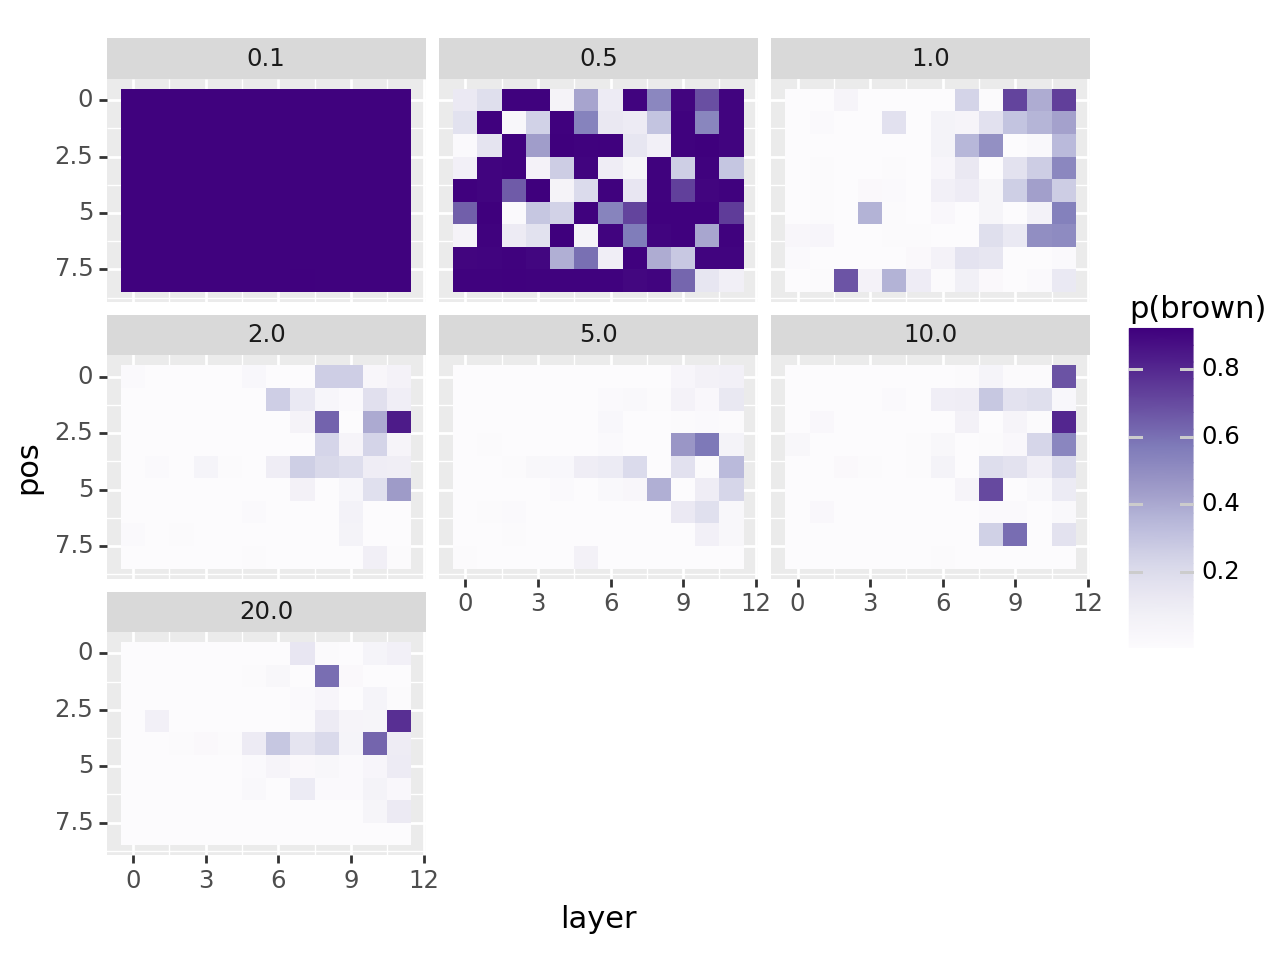

In [23]:
df = pd.DataFrame(data)
df["layer"] = df["layer"].astype(int)
df["pos"] = df["pos"].astype(int)
df["p(brown)"] = df["p(brown)"].astype(float)

plot = (
    ggplot(df, aes(x="layer", y="pos"))
    + scale_y_reverse()
    + geom_tile(aes(fill="p(brown)"))
    + scale_fill_cmap("Purples")
    + facet_wrap("noise_level")
)
print(plot)

### Sampling noise and running repeatedly

In [26]:
base = inputs
data = []
with torch.inference_mode():
    for i in range(10):
        for layer_i in tqdm(range(12)):
            for pos_i in range(9):
                config = restore_corrupted_config(
                    type(blip), layer_i, noise_level=1.0
                )
                intervenable = IntervenableModel(config, blip)
                _, counterfactual_outputs = intervenable(
                    base,
                    [base, base],
                    {
                        "sources->base": (
                            [
                                [[0, 1, 2, 3, 4, 5, 6, 7, 8]],
                                [
                                    [
                                        pos_i,
                                        pos_i,
                                        pos_i,
                                        pos_i,
                                        pos_i,
                                        pos_i,
                                        pos_i,
                                        pos_i,
                                        pos_i,
                                    ]
                                ],
                            ],
                            [
                                [[0, 1, 2, 3, 4, 5, 6, 7, 8]],
                                [
                                    [
                                        pos_i,
                                        pos_i,
                                        pos_i,
                                        pos_i,
                                        pos_i,
                                        pos_i,
                                        pos_i,
                                        pos_i,
                                        pos_i,
                                    ]
                                ],
                            ],
                        )
                    },
                )
                logits = counterfactual_outputs["decoder_logits"][0, 0].softmax(-1)
                p_brown = logits[2829]
                data.append(
                    {
                        "layer": layer_i,
                        "pos": pos_i,
                        "p(brown)": p_brown.item(),
                        "iteration": i,
                    }
                )
        df = pd.DataFrame(data)
        avg_p = df[df["iteration"] == i]["p(brown)"].mean()
        print(f"average prob so far: {avg_p:.2%}")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:21<00:00,  1.78s/it]


average prob so far: 9.13%


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:21<00:00,  1.78s/it]


average prob so far: 7.91%


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:21<00:00,  1.78s/it]


average prob so far: 7.51%


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:21<00:00,  1.78s/it]


average prob so far: 8.36%


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:21<00:00,  1.79s/it]


average prob so far: 9.84%


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:21<00:00,  1.78s/it]


average prob so far: 8.33%


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:21<00:00,  1.78s/it]


average prob so far: 8.20%


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:21<00:00,  1.78s/it]


average prob so far: 7.92%


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:21<00:00,  1.78s/it]


average prob so far: 8.24%


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:21<00:00,  1.78s/it]

average prob so far: 8.59%


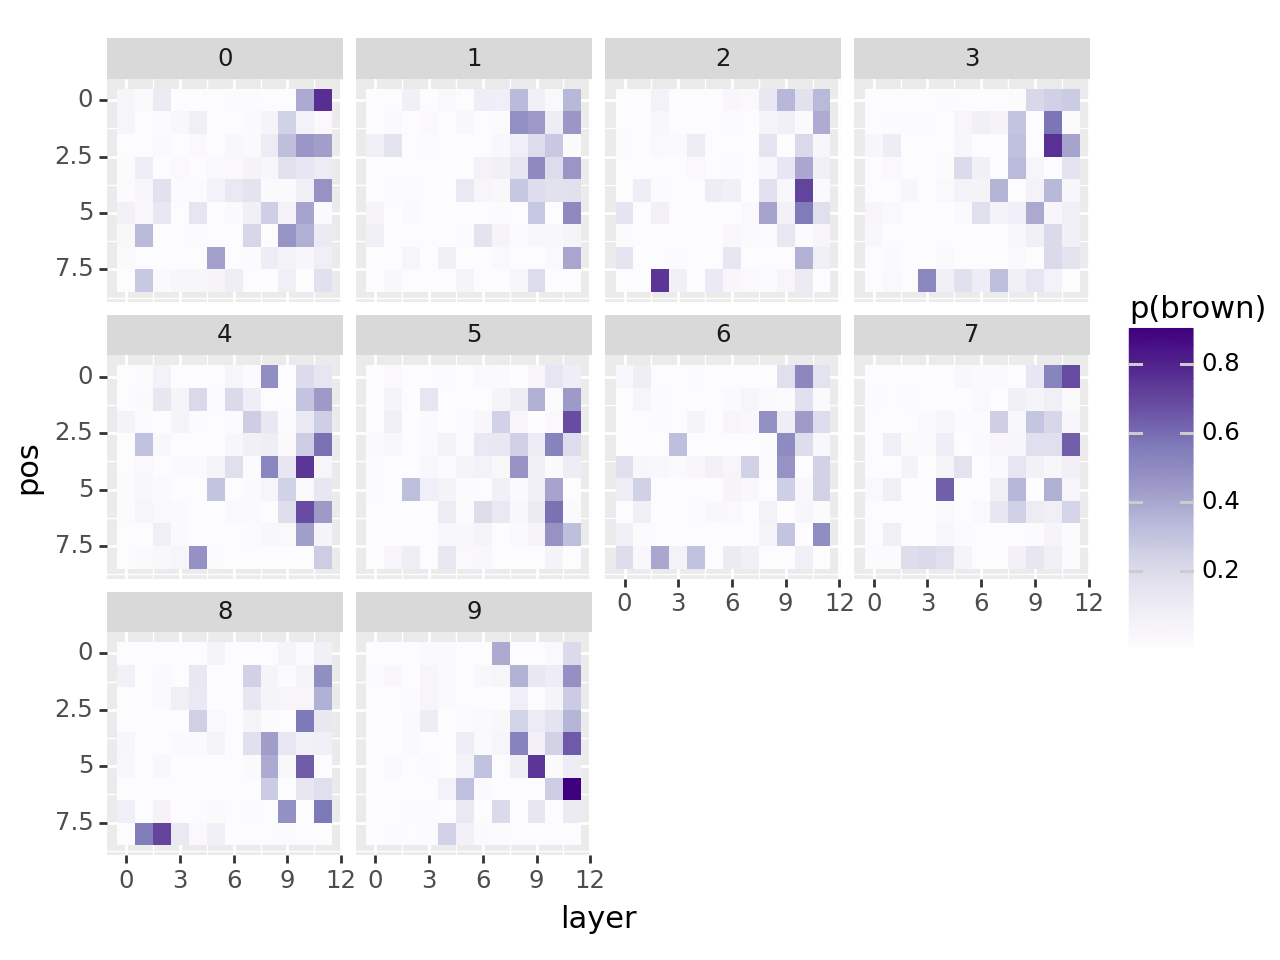

In [27]:
df = pd.DataFrame(data)
df["layer"] = df["layer"].astype(int)
df["pos"] = df["pos"].astype(int)
df["p(brown)"] = df["p(brown)"].astype(float)

plot = (
    ggplot(df, aes(x="layer", y="pos"))
    + scale_y_reverse()
    + geom_tile(aes(fill="p(brown)"))
    + scale_fill_cmap("Purples")
    + facet_wrap("iteration")
)
print(plot)

     layer  pos  p(brown)  iteration
0        0    0  0.008152        4.5
1        0    1  0.015465        4.5
2        0    2  0.022314        4.5
3        0    3  0.003820        4.5
4        0    4  0.025465        4.5
..     ...  ...       ...        ...
103     11    4  0.193646        4.5
104     11    5  0.137404        4.5
105     11    6  0.209949        4.5
106     11    7  0.234223        4.5
107     11    8  0.048529        4.5

[108 rows x 4 columns]


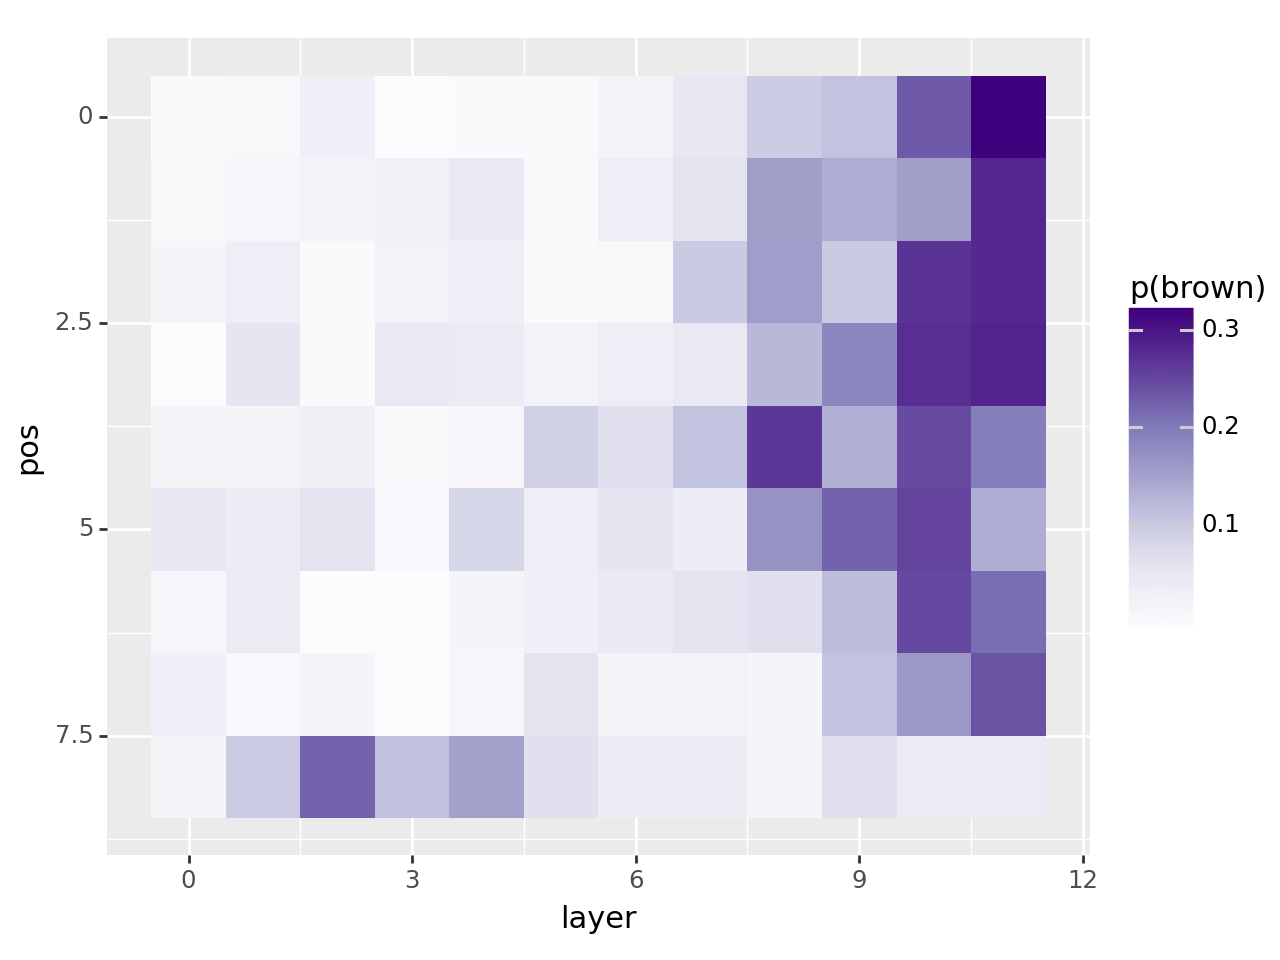

In [31]:
df = pd.DataFrame(data)
df["layer"] = df["layer"].astype(int)
df["pos"] = df["pos"].astype(int)
df["p(brown)"] = df["p(brown)"].astype(float)
df = df.groupby(["layer", "pos"]).mean().reset_index()
print(df)

plot = (
    ggplot(df, aes(x="layer", y="pos"))
    + scale_y_reverse()
    + geom_tile(aes(fill="p(brown)"))
    + scale_fill_cmap("Purples")
)
print(plot)